Импортируем библиотеки

In [132]:
import pyodbc

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import RidgeCV, LassoCV

from sklearn.decomposition import PCA

from xgboost.callback import EarlyStopping
from xgboost import XGBRegressor
from xgboost import plot_importance

import shap

import math

Сравнительный анализ по моделям

In [137]:
results = []

def evaluate_model(name, y_true, y_pred, alpha=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'Модель': name,
        'R²': round(r2, 4),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MSE': round(mse, 2),
        'alpha': alpha if alpha is not None else "-"
    })

Отображем все столбцы и все колонки

In [76]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Импортируем датасеты для обучения и проверки, обучаться будем на данных с 2011 года по 2023, предсказывать будем 2024 год

In [ ]:
conn = pyodbc.connect("DSN=vertica")
query_train = "SELECT * FROM cards_2011_2023_plus where n_week_week < 53"
query_test = "SELECT * FROM cards_2011_2023_2024_plus where n_week_week < 53"

df_train = pd.read_sql(query_train, conn)
df_test = pd.read_sql(query_test, conn)

Изучаем данные

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   dd_calendar         4371 non-null   object        
 1   sls_rub             4371 non-null   object        
 2   prih_unt            4371 non-null   object        
 3   prih_rub            4371 non-null   object        
 4   mkdn_unt            969 non-null    object        
 5   mkdn_rub            969 non-null    object        
 6   discount_rub        4371 non-null   object        
 7   apoh                4371 non-null   object        
 8   eoh_unt             4371 non-null   object        
 9   eoh_rub             4371 non-null   object        
 10  dd_calendar_date    4371 non-null   datetime64[ns]
 11  n_year              4371 non-null   int64         
 12  n_month             4371 non-null   int64         
 13  n_week              4371 non-null   int64       

Т.к., столбцы object являются дубликатами столбцов типа int и float, удаляем все object

In [79]:
df_train = df_train.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])

Удаляем столбцы с продажами, они не нужны для текущего прогноза посетителей

In [80]:
df_train.drop(columns=['sls_rub_int', 'sls_unt'], inplace=True)
df_test.drop(columns=['sls_rub_int', 'sls_unt'], inplace=True)

In [81]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   dd_calendar_date    4371 non-null   datetime64[ns]
 1   n_year              4371 non-null   int64         
 2   n_month             4371 non-null   int64         
 3   n_week              4371 non-null   int64         
 4   prih_unt_int        4371 non-null   int64         
 5   prih_rub_int        4371 non-null   float64       
 6   mkdn_unt_int        4371 non-null   float64       
 7   mkdn_rub_int        4371 non-null   int64         
 8   discount_rub_int    4371 non-null   float64       
 9   apoh_int            4371 non-null   float64       
 10  eoh_unt_int         4371 non-null   float64       
 11  eoh_rub_int         4371 non-null   float64       
 12  discount_rub_prc    4371 non-null   float64       
 13  mkdn_rub_int_5days  4371 non-null   float64     

In [82]:
df_train.head()

,dd_calendar_date,n_year,n_month,n_week,prih_unt_int,prih_rub_int,mkdn_unt_int,mkdn_rub_int,discount_rub_int,apoh_int,eoh_unt_int,eoh_rub_int,discount_rub_prc,mkdn_rub_int_5days,sms,dow,n_year_week,n_month_week,n_week_week,st_area,napoln,napoln_rub,visiors,cr,sls_rub_int_year,visiors_year,sls_rub_online,sls_unt_online,sls_rub_online_prc,sls_unt_online_prc
0,2015-02-01,2015,2,6,-4938,-1769016.0,0.0,0,3182855.0,482.83,11278613.0,5.445630e+09,0.065050,0.0,False,0,2015,2,5,261357,43.154050,20835.981608,379783.88,0.152502,24583415344,152891461,0.0,0.0,0.00,0.00
1,2016-02-01,2016,2,6,65277,32626419.0,0.0,0,1920342.0,454.45,7518669.0,3.416893e+09,0.068857,7776784.0,True,1,2016,2,5,265536,28.315065,12867.910295,209344.38,0.163300,33741162439,179584716,0.0,0.0,0.00,0.00
2,2013-03-01,2013,3,9,530632,162563587.0,22425.0,1861335,5698957.0,275.43,21066518.0,5.802454e+09,0.070318,206199376.0,True,5,2013,2,9,425946,49.458190,13622.510607,413333.13,0.270634,27483400906,176529919,0.0,0.0,0.00,0.00
3,2014-04-01,2014,4,14,614029,209821180.0,0.0,0,3972664.0,326.57,27314986.0,8.920263e+09,0.081256,0.0,False,2,2014,4,14,283953,96.195448,31414.574046,307769.13,0.188151,27949854997,175531418,0.0,0.0,0.00,0.00
4,2021-04-01,2021,4,14,472607,357672532.0,0.0,0,7547998.0,697.30,16253880.0,1.133377e+10,0.083555,0.0,False,4,2021,3,13,376056,43.221967,30138.511514,358351.88,0.183319,48880040288,183992784,6326668.5,11304.0,0.08,0.08


In [83]:
df_train.describe()

,dd_calendar_date,n_year,n_month,n_week,prih_unt_int,prih_rub_int,mkdn_unt_int,mkdn_rub_int,discount_rub_int,apoh_int,eoh_unt_int,eoh_rub_int,discount_rub_prc,mkdn_rub_int_5days,dow,n_year_week,n_month_week,n_week_week,st_area,napoln,napoln_rub,visiors,cr,sls_rub_int_year,visiors_year,sls_rub_online,sls_unt_online,sls_rub_online_prc,sls_unt_online_prc
count,4371,4371.000000,4371.000000,4371.000000,4.371000e+03,4.371000e+03,4.371000e+03,4.371000e+03,4.371000e+03,4371.000000,4.371000e+03,4.371000e+03,4371.000000,4.371000e+03,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4.371000e+03,4371.000000,4.371000e+03,4.371000e+03,4.371000e+03,4371.000000,4371.000000,4371.000000
mean,2017-04-02 06:35:39.739190016,2016.752459,6.522764,26.981698,2.595643e+05,1.479373e+08,1.843581e+05,3.366497e+07,7.975371e+06,516.577472,1.670625e+07,8.557395e+09,0.069891,1.688822e+08,3.000458,2016.752231,6.503775,26.517502,309414.748799,59.109717,26877.587565,4.778696e+05,0.205928,3.579396e+10,1.742052e+08,4.445366e+06,7511.683596,0.033699,0.040130
min,2011-01-03 00:00:00,2011.000000,1.000000,1.000000,-1.195830e+07,-4.598298e+08,-5.240000e+02,-8.219734e+08,7.391800e+04,221.160000,4.116766e+06,1.470968e+09,0.019248,-8.219734e+08,0.000000,2011.000000,1.000000,1.000000,98471.000000,11.912089,9138.790518,2.152368e+04,0.024378,2.670609e+08,1.194830e+06,-1.941991e+06,-10019.000000,-0.010000,-0.020000
25%,2013-12-30 12:00:00,2013.000000,4.000000,14.000000,1.053600e+05,5.684998e+07,0.000000e+00,0.000000e+00,3.587973e+06,330.800000,1.245171e+07,5.506423e+09,0.055295,0.000000e+00,1.000000,2014.000000,4.000000,14.000000,255227.000000,40.597037,21003.627116,3.409669e+05,0.189864,2.458342e+10,1.528915e+08,0.000000e+00,0.000000,0.000000,0.000000
50%,2017-01-03 00:00:00,2017.000000,7.000000,27.000000,2.145360e+05,1.116119e+08,0.000000e+00,0.000000e+00,5.968978e+06,458.690000,1.564812e+07,7.207976e+09,0.067513,2.131436e+06,3.000000,2017.000000,7.000000,27.000000,308706.000000,51.136564,25671.580986,4.495770e+05,0.208132,3.374116e+10,1.788863e+08,0.000000e+00,0.000000,0.000000,0.000000
75%,2021-01-02 12:00:00,2021.000000,10.000000,40.000000,3.700600e+05,1.982147e+08,0.000000e+00,0.000000e+00,9.919008e+06,574.530000,2.084598e+07,1.074602e+10,0.079108,2.269013e+08,5.000000,2020.000000,10.000000,40.000000,368143.000000,76.760375,31747.798513,5.852969e+05,0.223930,4.066079e+10,1.839928e+08,1.458045e+06,4417.000000,0.020000,0.020000
max,2023-12-31 00:00:00,2023.000000,12.000000,53.000000,1.328593e+07,2.026275e+09,1.234386e+07,3.538844e+09,8.895266e+07,2706.520000,3.155159e+07,2.723714e+10,0.280262,3.538844e+09,6.000000,2023.000000,12.000000,52.000000,857048.000000,120.569991,54727.773226,1.160907e+06,0.375537,5.918365e+10,2.156020e+08,5.773509e+07,112641.000000,0.660000,1.250000
std,NaN,3.790997,3.442116,15.029434,3.800805e+05,1.385141e+08,7.503607e+05,1.568826e+08,6.974830e+06,236.092049,5.282893e+06,4.612995e+09,0.022987,3.316279e+08,2.000801,3.788779,3.446840,15.019754,99698.589378,23.712990,7843.363524,1.793623e+05,0.028461,1.243492e+10,2.914598e+07,9.111525e+06,14844.986401,0.068830,0.084567


Проверка на пустоту

In [84]:
df_train.isna().sum()

dd_calendar_date      0
n_year                0
n_month               0
n_week                0
prih_unt_int          0
prih_rub_int          0
mkdn_unt_int          0
mkdn_rub_int          0
discount_rub_int      0
apoh_int              0
eoh_unt_int           0
eoh_rub_int           0
discount_rub_prc      0
mkdn_rub_int_5days    0
sms                   0
dow                   0
n_year_week           0
n_month_week          0
n_week_week           0
st_area               0
napoln                0
napoln_rub            0
visiors               0
cr                    0
sls_rub_int_year      0
visiors_year          0
sls_rub_online        0
sls_unt_online        0
sls_rub_online_prc    0
sls_unt_online_prc    0
dtype: int64

In [85]:
df_test.isna().sum()

dd_calendar_date      0
n_year                0
n_month               0
n_week                0
prih_unt_int          0
prih_rub_int          0
mkdn_unt_int          0
mkdn_rub_int          0
discount_rub_int      0
apoh_int              0
eoh_unt_int           0
eoh_rub_int           0
discount_rub_prc      0
mkdn_rub_int_5days    0
sms                   0
dow                   0
n_year_week           0
n_month_week          0
n_week_week           0
st_area               0
napoln                0
napoln_rub            0
visiors               0
cr                    0
sls_rub_int_year      0
visiors_year          0
sls_rub_online        0
sls_unt_online        0
sls_rub_online_prc    0
sls_unt_online_prc    0
dtype: int64

Посмотрим на выбросы

In [121]:
lof = LocalOutlierFactor(n_neighbors=20)
labels = lof.fit_predict(df_train.select_dtypes(include='number'))

outliers = df_train[labels == -1]

In [129]:
outliers.shape[0] / df_train.shape[0]

0.08556394417753374

Построим корреляции

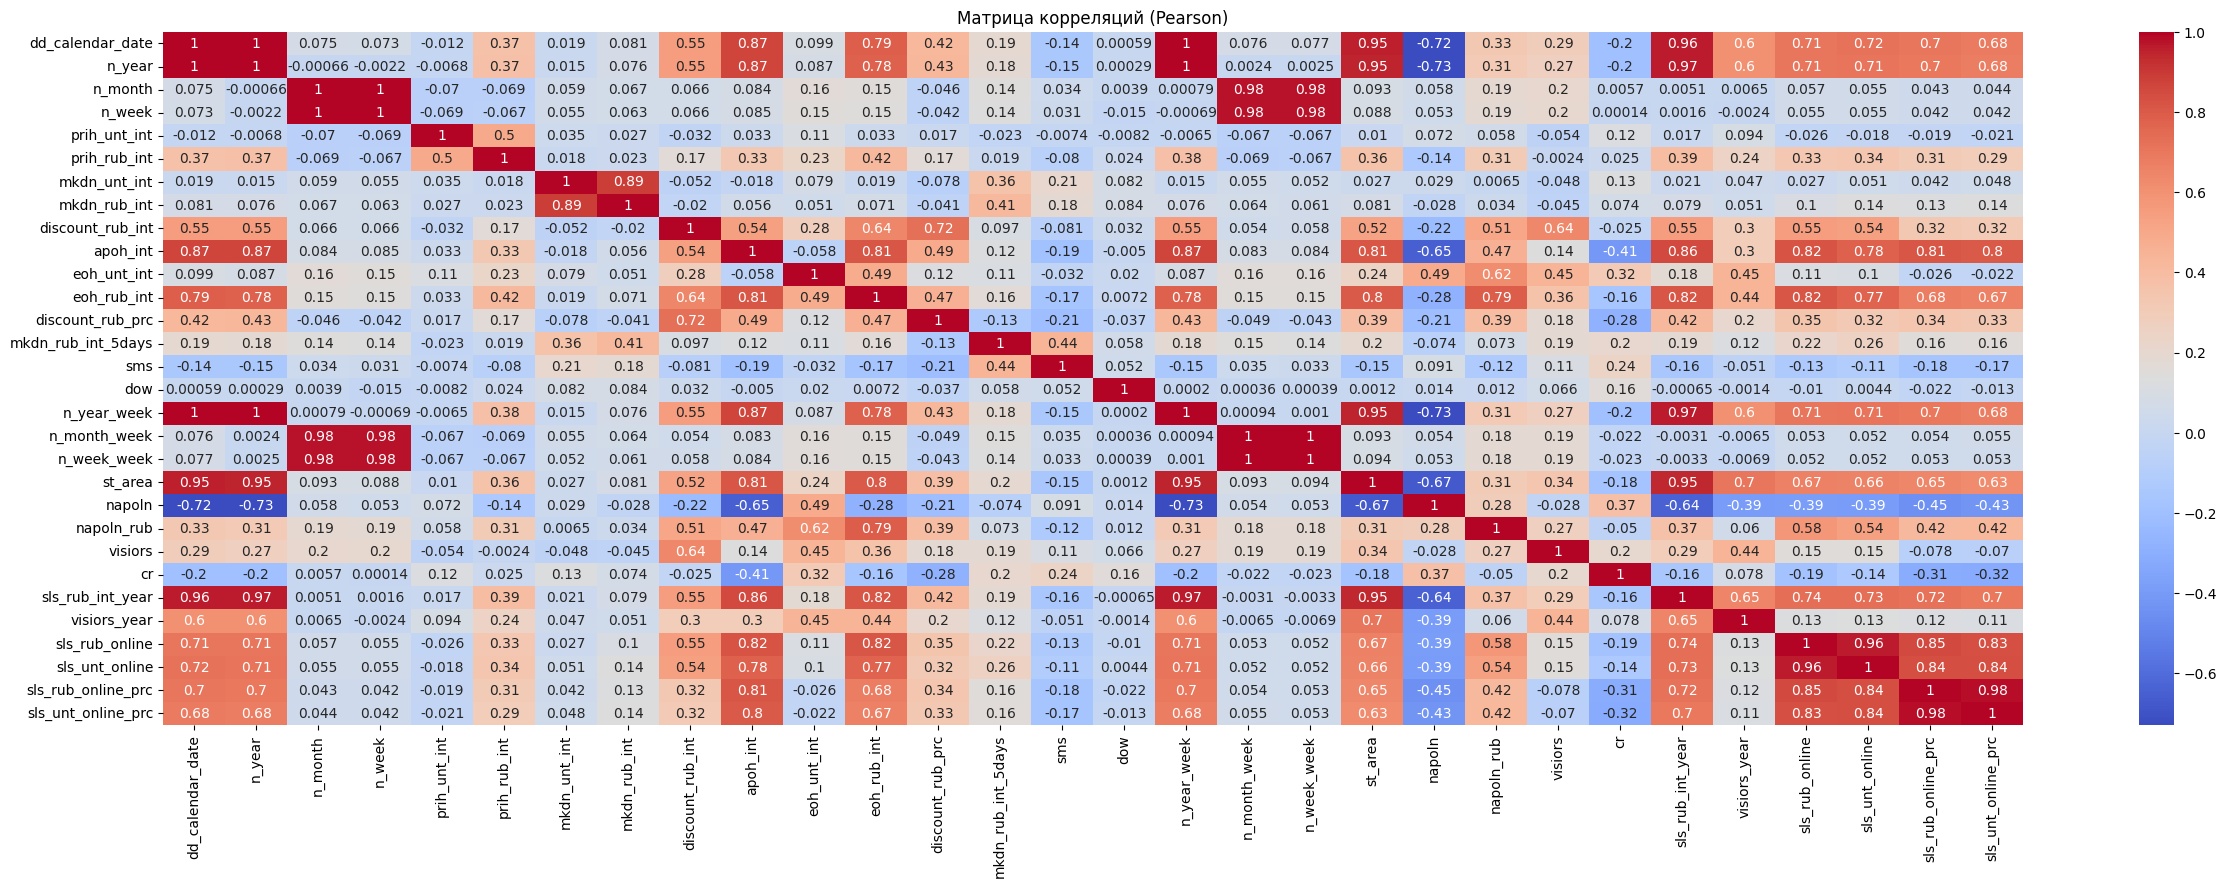

In [86]:
plt.figure(figsize=(30,9))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций (Pearson)')
plt.show()

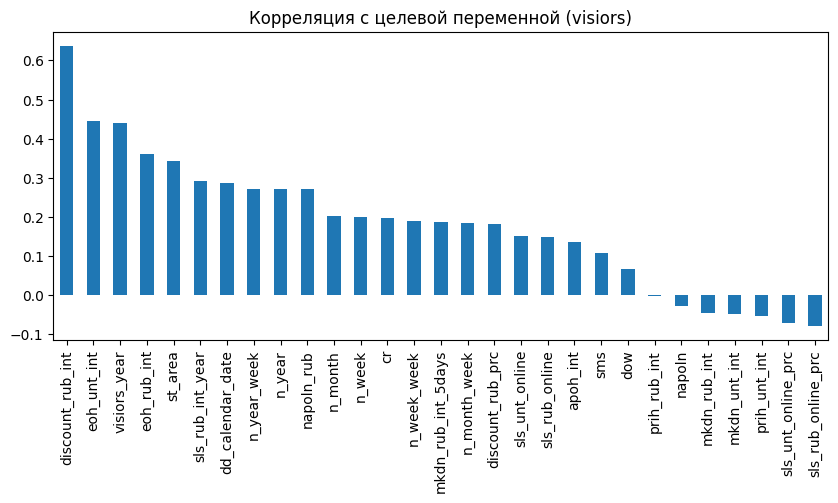

In [87]:
target_corr = df_train.corr()['visiors'].sort_values(ascending=False)
target_corr.drop('visiors').plot(kind='bar', figsize=(10, 4))
plt.title('Корреляция с целевой переменной (visiors)')
plt.show()

Попробуем посмотреть, какой скейлер лучше

In [88]:
column_for_model = ['visiors','dd_calendar_date','prih_unt_int','prih_rub_int','mkdn_unt_int','mkdn_rub_int','discount_rub_int','apoh_int','eoh_unt_int','eoh_rub_int','discount_rub_prc','mkdn_rub_int_5days','sms','dow','n_year_week','n_month_week','n_week_week','st_area','napoln','napoln_rub','sls_rub_int_year','visiors_year','sls_rub_online','sls_unt_online','sls_rub_online_prc','sls_unt_online_prc']

df_train[column_for_model].head()

,visiors,dd_calendar_date,prih_unt_int,prih_rub_int,mkdn_unt_int,mkdn_rub_int,discount_rub_int,apoh_int,eoh_unt_int,eoh_rub_int,discount_rub_prc,mkdn_rub_int_5days,sms,dow,n_year_week,n_month_week,n_week_week,st_area,napoln,napoln_rub,sls_rub_int_year,visiors_year,sls_rub_online,sls_unt_online,sls_rub_online_prc,sls_unt_online_prc
0,379783.88,2015-02-01,-4938,-1769016.0,0.0,0,3182855.0,482.83,11278613.0,5.445630e+09,0.065050,0.0,False,0,2015,2,5,261357,43.154050,20835.981608,24583415344,152891461,0.0,0.0,0.00,0.00
1,209344.38,2016-02-01,65277,32626419.0,0.0,0,1920342.0,454.45,7518669.0,3.416893e+09,0.068857,7776784.0,True,1,2016,2,5,265536,28.315065,12867.910295,33741162439,179584716,0.0,0.0,0.00,0.00
2,413333.13,2013-03-01,530632,162563587.0,22425.0,1861335,5698957.0,275.43,21066518.0,5.802454e+09,0.070318,206199376.0,True,5,2013,2,9,425946,49.458190,13622.510607,27483400906,176529919,0.0,0.0,0.00,0.00
3,307769.13,2014-04-01,614029,209821180.0,0.0,0,3972664.0,326.57,27314986.0,8.920263e+09,0.081256,0.0,False,2,2014,4,14,283953,96.195448,31414.574046,27949854997,175531418,0.0,0.0,0.00,0.00
4,358351.88,2021-04-01,472607,357672532.0,0.0,0,7547998.0,697.30,16253880.0,1.133377e+10,0.083555,0.0,False,4,2021,3,13,376056,43.221967,30138.511514,48880040288,183992784,6326668.5,11304.0,0.08,0.08


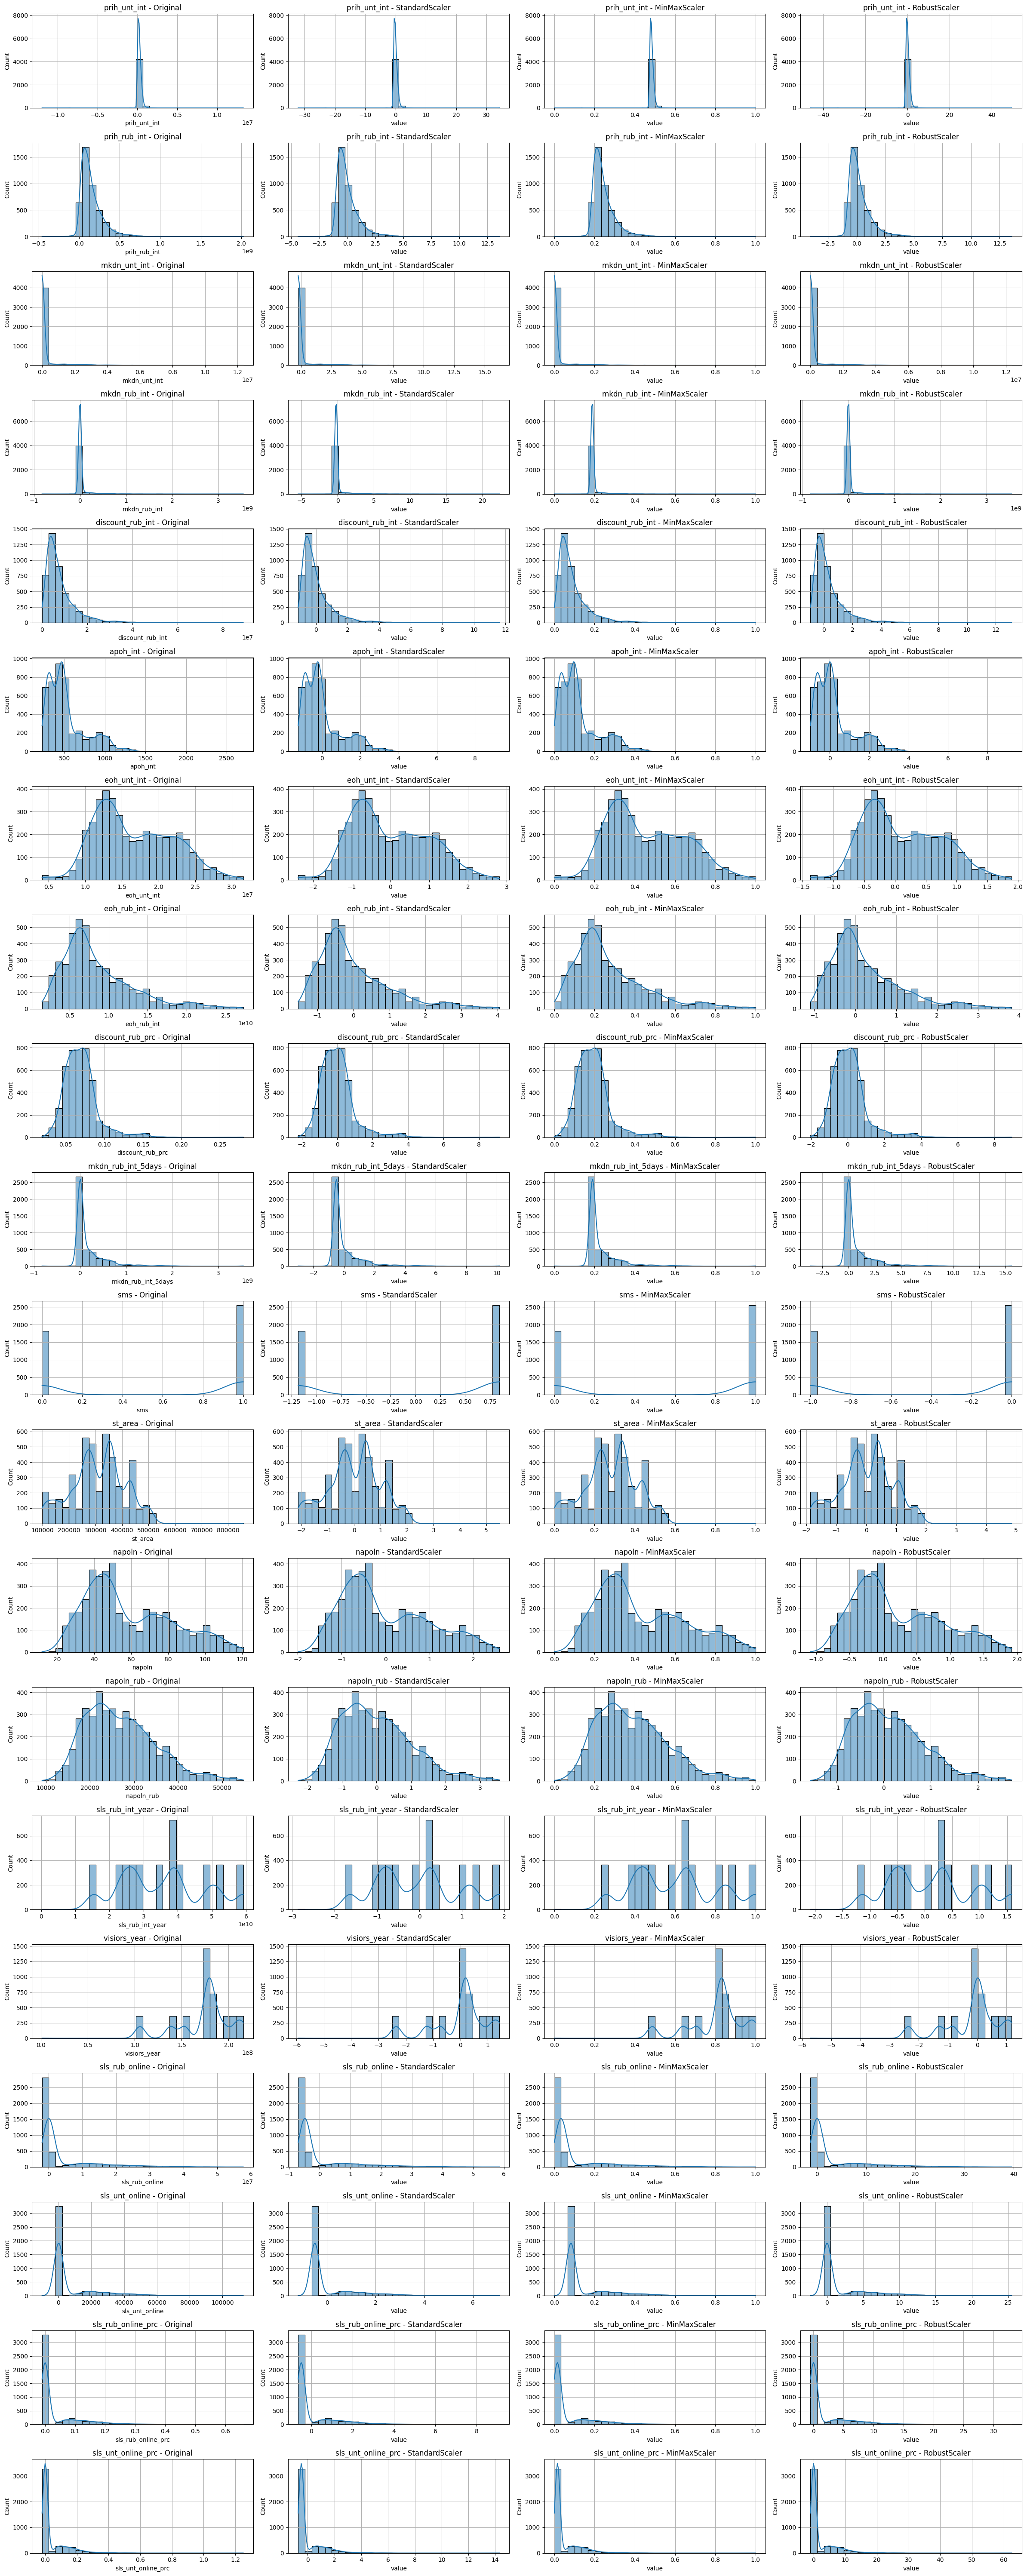

In [89]:
df = df_train[column_for_model]

# Оставим только числовые признаки
columns_to_scale = ['prih_unt_int','prih_rub_int','mkdn_unt_int','mkdn_rub_int','discount_rub_int','apoh_int','eoh_unt_int','eoh_rub_int','discount_rub_prc','mkdn_rub_int_5days','sms','st_area','napoln','napoln_rub','sls_rub_int_year','visiors_year','sls_rub_online','sls_unt_online','sls_rub_online_prc','sls_unt_online_prc']

# Инициализация скейлеров
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Применение скейлеров и формирование объединённого датафрейма для визуализации
scaled_dfs = []
for scaler_name, scaler in scalers.items():
    scaled = scaler.fit_transform(df[columns_to_scale])
    scaled_df = pd.DataFrame(scaled, columns=columns_to_scale)
    melted_df = scaled_df.melt(var_name='feature', value_name='value')
    melted_df['scaler'] = scaler_name
    scaled_dfs.append(melted_df)

viz_df = pd.concat(scaled_dfs, ignore_index=True)

# Используем все числовые признаки
selected_features = columns_to_scale

# Подготовка к визуализации: 4 графика на каждый признак
cols = 4
rows = math.ceil(len(selected_features) * 4 / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3))
axes = axes.flatten()

plot_idx = 0
for feature in selected_features:
    # Оригинал
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[plot_idx])
    axes[plot_idx].set_title(f"{feature} - Original")
    axes[plot_idx].grid(True)
    plot_idx += 1

    # Три скейлера
    for scaler_name in scalers.keys():
        subset = viz_df[(viz_df['feature'] == feature) & (viz_df['scaler'] == scaler_name)]
        sns.histplot(subset['value'], bins=30, kde=True, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"{feature} - {scaler_name}")
        axes[plot_idx].grid(True)
        plot_idx += 1

# Удаление пустых осей, если есть
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Мин макс скейлер дает худший результат, выбрал RobustScaler

In [90]:
features_to_scale = ['dow', 'n_year_week', 'n_month_week', 'n_week_week', 'prih_unt_int','prih_rub_int','mkdn_unt_int','mkdn_rub_int','discount_rub_int','apoh_int','eoh_unt_int','eoh_rub_int','discount_rub_prc','mkdn_rub_int_5days','sms','st_area','napoln','napoln_rub','cr','sls_rub_int_year','visiors_year','sls_rub_online','sls_unt_online','sls_rub_online_prc','sls_unt_online_prc']

scaler = RobustScaler()
# scaler = StandardScaler()
scaler.fit(df_train[features_to_scale])

df_train_scaled = df_train.copy()
df_train_scaled[features_to_scale] = scaler.transform(df_train_scaled[features_to_scale])

#df_train_scaled.head()

In [91]:
df_test_scaled = df_test.copy()
df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

#df_test_scaled.head()

In [92]:
# Преобразуем месяц и день недели в циклические признаки
df_train_scaled['month_sin'] = np.sin(2 * np.pi * df_train['n_month_week'] / 12)
df_train_scaled['month_cos'] = np.cos(2 * np.pi * df_train['n_month_week'] / 12)

df_train_scaled['dow_sin'] = np.sin(2 * np.pi * df_train['dow'] / 7)
df_train_scaled['dow_cos'] = np.cos(2 * np.pi * df_train['dow'] / 7)

df_train_scaled['n_week_week_sin'] = np.sin(2 * np.pi * df_train['n_week_week'] / 52)
df_train_scaled['n_week_week_cos'] = np.cos(2 * np.pi * df_train['n_week_week'] / 52)

df_test_scaled['month_sin'] = np.sin(2 * np.pi * df_test['n_month_week'] / 12)
df_test_scaled['month_cos'] = np.cos(2 * np.pi * df_test['n_month_week'] / 12)

df_test_scaled['dow_sin'] = np.sin(2 * np.pi * df_test['dow'] / 7)
df_test_scaled['dow_cos'] = np.cos(2 * np.pi * df_test['dow'] / 7)

df_test_scaled['n_week_week_sin'] = np.sin(2 * np.pi * df_test['n_week_week'] / 52)
df_test_scaled['n_week_week_cos'] = np.cos(2 * np.pi * df_test['n_week_week'] / 52)


Выбираем фичи для модели

In [93]:
features_to_pred = ['n_week_week_sin', 'n_week_week_cos', 'month_sin', 'month_cos','dow_sin', 'dow_cos', 'prih_rub_int','discount_rub_int', 'eoh_rub_int', 'discount_rub_prc', 'mkdn_rub_int_5days', 'eoh_unt_int', 'st_area', 'napoln', 'apoh_int', 'sls_rub_online_prc', 'sls_unt_online_prc','sls_rub_int_year', 'sms']

Делим датасеты на X и Y

In [141]:
X_train = df_train_scaled[features_to_pred]
Y_train = np.log1p(df_train_scaled['visiors'])   # логарифмируем целевую переменную для лучшего результата

X_test = df_test_scaled[features_to_pred]
Y_test = df_test_scaled['visiors']

In [143]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train, Y_train)

predict_LinearRegression = np.expm1(model_LinearRegression.predict(X_test))

print("Linear:")
print("  R2:", r2_score(Y_test, predict_LinearRegression))
print("  MSE:", mean_squared_error(Y_test, predict_LinearRegression))



Linear:
  R2: 0.7716771517262606
  MSE: 4991928112.182777


In [146]:
model_RidgeCV = RidgeCV(alphas=[0.01, 0.1, 1.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 10.0, 11.0, 11.6, 12.0, 15.0, 100.0], cv=6)
model_RidgeCV.fit(X_train, Y_train)

predict_RidgeCV = np.expm1(model_RidgeCV.predict(X_test))

print("Ridge:")
print("  Best alpha:", model_RidgeCV.alpha_)
print("  R2:", r2_score(Y_test, predict_RidgeCV))
print("  MSE:", mean_squared_error(Y_test, predict_RidgeCV))

Ridge:
  Best alpha: 7.0
  R2: 0.7690223959062968
  MSE: 5049970267.441674


In [150]:
# Lasso: с автоматическим подбором альфы
model_LassoCV = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], cv=7, max_iter=100000)
model_LassoCV.fit(X_train, Y_train)

predict_LassoCV = np.expm1(model_LassoCV.predict(X_test))

print("Lasso:")
print("  Best alpha:", model_LassoCV.alpha_)
print("  R2:", r2_score(Y_test, predict_LassoCV))
print("  MSE:", mean_squared_error(Y_test, predict_LassoCV))

Lasso:
  Best alpha: 0.0001
  R2: 0.7710762503859742
  MSE: 5005065896.315656


Пытаюсь добавить PolynomialFeatures, но качество резко ухудшается, модель переобучается

In [153]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [154]:
print("Признаков до полинома:", X_train.shape[1])
print("Признаков после полинома:", X_train_poly.shape[1])

Признаков до полинома: 19
Признаков после полинома: 190


In [156]:
poly_model_LinearRegression = LinearRegression()
poly_model_LinearRegression.fit(X_train_poly, Y_train)

predict_LinearRegression_poly = np.expm1(poly_model_LinearRegression.predict(X_test_poly))

print("Linear:")
print("  R2:", r2_score(Y_test, predict_LinearRegression_poly))
print("  MSE:", mean_squared_error(Y_test, predict_LinearRegression_poly))

Linear:
  R2: -0.06355140349783595
  MSE: 23252916604.767715


In [158]:
poly_model_RidgeCV = RidgeCV(alphas=[0.01, 0.1, 1.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 10.0, 11.0, 11.6, 12.0, 15.0, 16.0, 17.0, 18.0, 19.0, 30.0, 100.0], cv=6)
poly_model_RidgeCV.fit(X_train_poly, Y_train)

predict_RidgeCV_poly = np.expm1(poly_model_RidgeCV.predict(X_test_poly))

print("Ridge:")
print("  Best alpha:", poly_model_RidgeCV.alpha_)
print("  R2:", r2_score(Y_test, predict_RidgeCV_poly))
print("  MSE:", mean_squared_error(Y_test, predict_RidgeCV_poly))

Ridge:
  Best alpha: 19.0
  R2: 0.02666599460172081
  MSE: 21280451872.542492


In [160]:
# Lasso: с автоматическим подбором альфы
poly_model_LassoCV = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], cv=7, max_iter=100000)
poly_model_LassoCV.fit(X_train_poly, Y_train)

predict_LassoCV_poly = np.expm1(poly_model_LassoCV.predict(X_test_poly))

print("Lasso:")
print("  Best alpha:", poly_model_LassoCV.alpha_)
print("  R2:", r2_score(Y_test, predict_LassoCV_poly))
print("  MSE:", mean_squared_error(Y_test, predict_LassoCV_poly))

Lasso:
  Best alpha: 0.001
  R2: 0.42288980622626726
  MSE: 12617627284.819101


XGBoost

In [162]:
features_to_pred_XGBoost = ['n_week_week_sin', 'n_week_week_cos', 'month_sin', 'month_cos','dow_sin', 'dow_cos', 'dow', 'prih_unt_int','prih_rub_int','mkdn_unt_int','mkdn_rub_int','discount_rub_int','apoh_int','eoh_unt_int','eoh_rub_int','discount_rub_prc','mkdn_rub_int_5days','sms','st_area','cr','sls_rub_int_year','visiors_year','sls_rub_online','sls_unt_online','sls_rub_online_prc','sls_unt_online_prc']

X_train_XGBoost = df_train_scaled[features_to_pred_XGBoost]
Y_train_XGBoost = np.log1p(df_train_scaled['visiors'])

X_test_XGBoost = df_test_scaled[features_to_pred_XGBoost]
Y_test_XGBoost = df_test_scaled['visiors']


# Обучение модели XGBoost
xgb_model = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
# xgb_model.fit(X_train, Y_train)

xgb_model.fit(
    X_train_XGBoost, Y_train_XGBoost,
    eval_set=[(X_test_XGBoost, np.log1p(Y_test_XGBoost))],
    verbose=100  # можно убрать, если слишком многословно
)

predict_XGBoost = np.expm1(xgb_model.predict(X_test_XGBoost))

print("XGBoost:")
print("  R2:", r2_score(Y_test_XGBoost, predict_XGBoost))
print("  MSE:", mean_squared_error(Y_test_XGBoost, predict_XGBoost))

train_preds_XGBoost = np.expm1(xgb_model.predict(X_train_XGBoost))
print("Train R2:", r2_score(np.expm1(Y_train_XGBoost), train_preds_XGBoost))

cv_r2 = cross_val_score(xgb_model, X_train_XGBoost, Y_train_XGBoost, cv=5, scoring='r2')
print("CV R2 mean:", cv_r2.mean())

[0]	validation_0-rmse:0.34161
[100]	validation_0-rmse:0.24178
[200]	validation_0-rmse:0.19526
[300]	validation_0-rmse:0.17260
[400]	validation_0-rmse:0.15312
[500]	validation_0-rmse:0.13898
[600]	validation_0-rmse:0.13127
[700]	validation_0-rmse:0.12663
[800]	validation_0-rmse:0.12435
[900]	validation_0-rmse:0.12279
[1000]	validation_0-rmse:0.12169
[1100]	validation_0-rmse:0.12107
[1200]	validation_0-rmse:0.12080
[1300]	validation_0-rmse:0.12081
[1400]	validation_0-rmse:0.12105
[1500]	validation_0-rmse:0.12119
[1600]	validation_0-rmse:0.12062
[1700]	validation_0-rmse:0.12024
[1800]	validation_0-rmse:0.12024
[1900]	validation_0-rmse:0.11990
[2000]	validation_0-rmse:0.11988
[2100]	validation_0-rmse:0.11977
[2200]	validation_0-rmse:0.11961
[2300]	validation_0-rmse:0.11942
[2400]	validation_0-rmse:0.11943
[2500]	validation_0-rmse:0.11927
[2600]	validation_0-rmse:0.11893
[2700]	validation_0-rmse:0.11869
[2800]	validation_0-rmse:0.11858
[2900]	validation_0-rmse:0.11851
[2999]	validation_0-rm

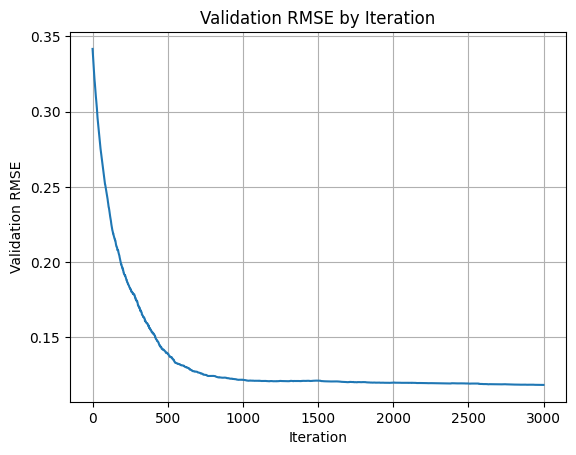

In [113]:
evals_result = xgb_model.evals_result()
rmse_vals = evals_result['validation_0']['rmse']

import matplotlib.pyplot as plt
plt.plot(rmse_vals)
plt.xlabel("Iteration")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE by Iteration")
plt.grid(True)
plt.show()


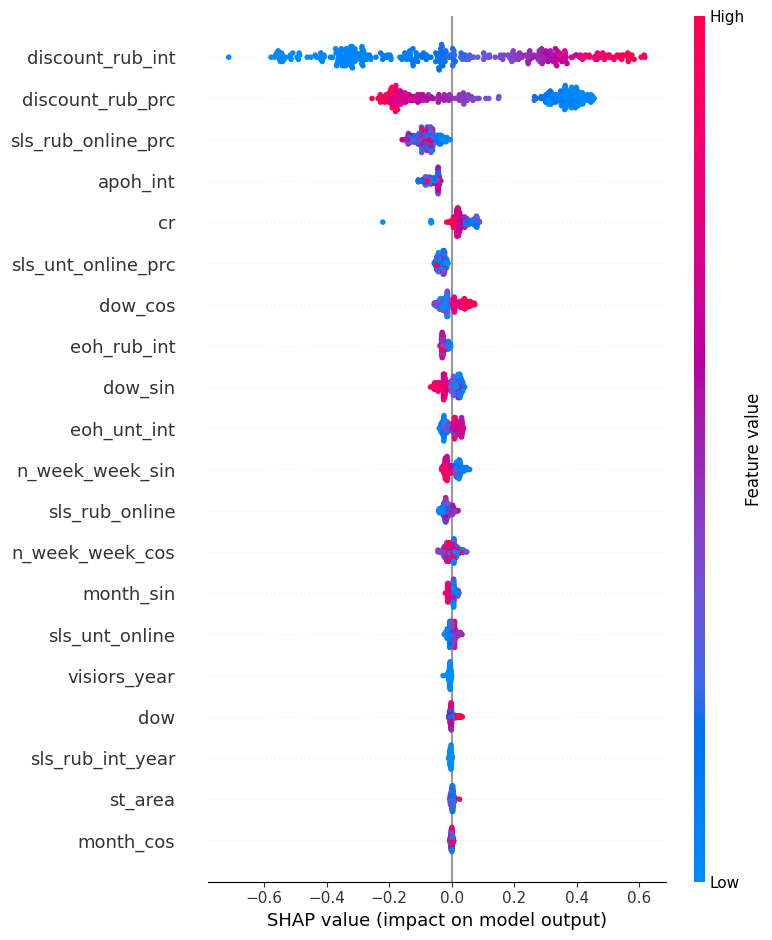

In [114]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


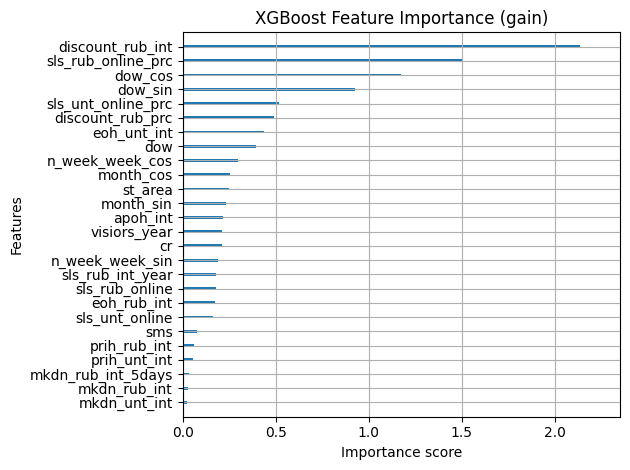

In [115]:
# Важность признаков
xgb_model.get_booster().feature_names = features_to_pred_XGBoost

# Построим график важности
plot_importance(xgb_model, importance_type='gain', show_values=False)
plt.title("XGBoost Feature Importance (gain)")
plt.tight_layout()
plt.show()

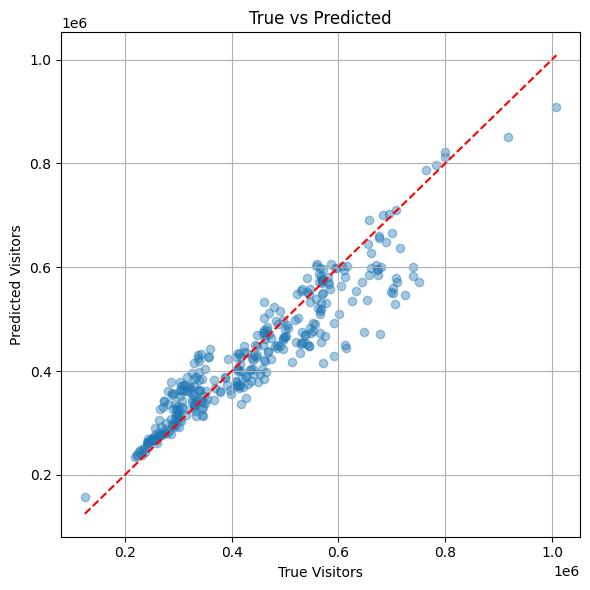

In [116]:
#Визуализация: y_true vs y_pred

plt.figure(figsize=(6, 6))
plt.scatter(Y_test, predict, alpha=0.4)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('True Visitors')
plt.ylabel('Predicted Visitors')
plt.title('True vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

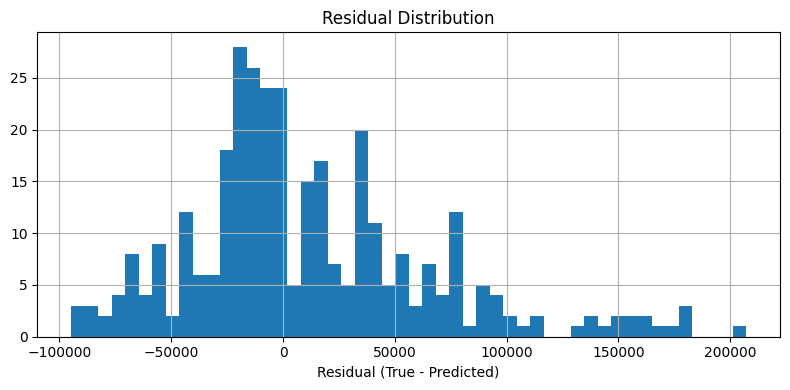

In [117]:
#Остатки (ошибки предсказания)

residuals = Y_test - predict
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [163]:
results = []

evaluate_model('Linear Regression', Y_test, predict_LinearRegression)
evaluate_model('RidgeCV', Y_test, predict_RidgeCV, alpha=model_RidgeCV.alpha_)
evaluate_model('LassoCV', Y_test, predict_LassoCV, alpha=model_LassoCV.alpha_)
evaluate_model('Linear Regression Poly', Y_test, predict_LinearRegression_poly)
evaluate_model('RidgeCV Poly', Y_test, predict_RidgeCV_poly, alpha=poly_model_RidgeCV.alpha_)
evaluate_model('LassoCV Poly', Y_test, predict_LassoCV_poly, alpha=poly_model_LassoCV.alpha_)
evaluate_model('XGBoost', Y_test_XGBoost, predict_XGBoost)

df_results = pd.DataFrame(results)
print(df_results)

                   Модель      R²        MAE       RMSE           MSE   alpha
0       Linear Regression  0.7717   55893.34   70653.58  4.991928e+09       -
1                 RidgeCV  0.7690   55818.98   71063.14  5.049970e+09     7.0
2                 LassoCV  0.7711   55767.19   70746.49  5.005066e+09  0.0001
3  Linear Regression Poly -0.0636  121914.64  152489.07  2.325292e+10       -
4            RidgeCV Poly  0.0267  116192.44  145878.21  2.128045e+10    19.0
5            LassoCV Poly  0.4229   81625.77  112328.21  1.261763e+10   0.001
6                 XGBoost  0.8588   40436.37   55570.85  3.088119e+09       -
